In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import CMAPSSLoader

In [2]:
loader = CMAPSSLoader()
df = loader.load_dataset('FD004')

Loaded FD004: 61249 records, 249 engines


In [3]:
print(f"Shape: {df.shape}")
print(f"Engines: {df['engine_id'].nunique()}")
df.head()

Shape: (61249, 27)
Engines: 249


,engine_id,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


**Shows**: How much training data exists at each RUL level - this is valuable to assess the data availability for machine learning

**Question**: "How balanced is my training data across the degradation spectrum?"

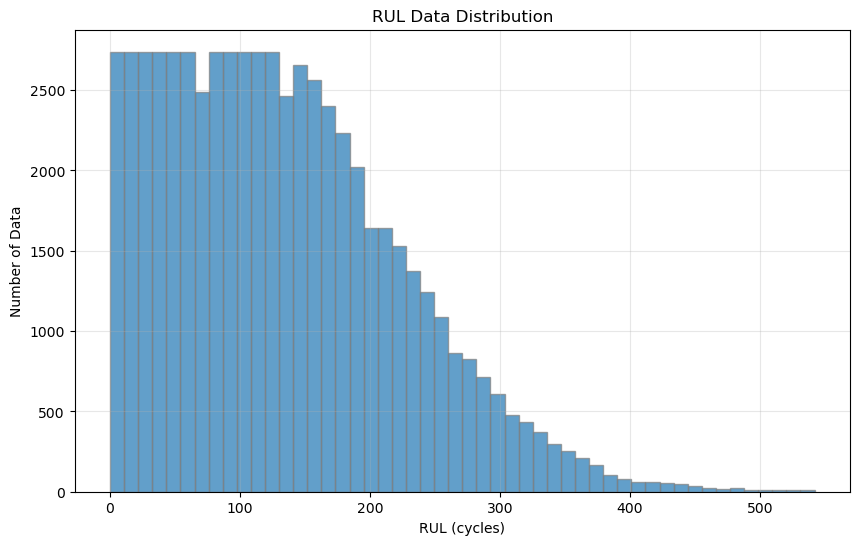

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df['RUL'], bins=50, alpha=0.7, edgecolor='grey')
plt.title('RUL Data Distribution')
plt.xlabel('RUL (cycles)')
plt.ylabel('Number of Data')
plt.grid(True, alpha=0.3)
plt.show()

**Shows**: How long each individual engine lasted - answers the actual engineering problem

**Question**: "What's the typical lifespan of engines in my fleet?"

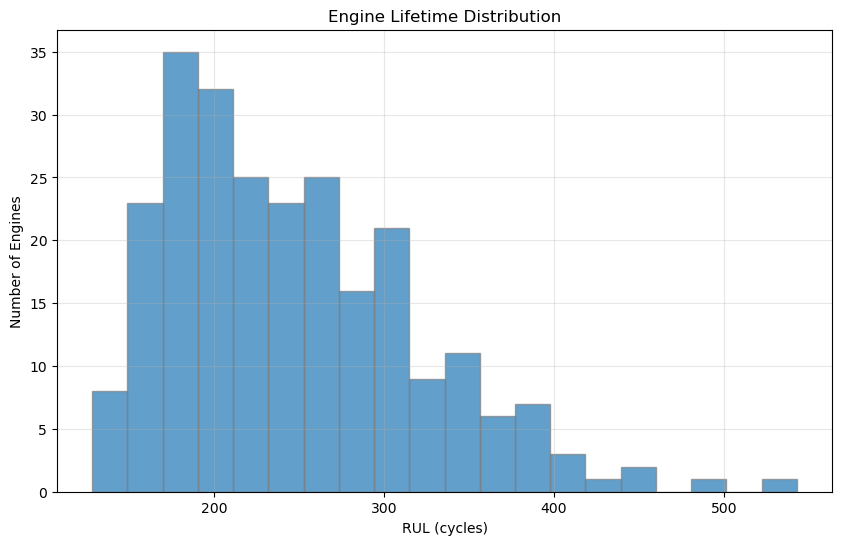

In [5]:
engine_lifetimes = df.groupby('engine_id')['time_cycles'].max()

plt.figure(figsize=(10, 6))
plt.hist(engine_lifetimes, bins=20, alpha=0.7, edgecolor='grey')
plt.title('Engine Lifetime Distribution')
plt.xlabel('RUL (cycles)')
plt.ylabel('Number of Engines')
plt.grid(True, alpha=0.3)
plt.show()

## Correlation Heatmap of Sensors
* **What it shows**: Pairwise correlation between all sensors. Red = strong positive correlation, blue = strong negative.

* **Why valuable**:

    * CMAPSS has many redundant sensors. Highly correlated sensors add little new information (they may be dropped).

    * Completely uncorrelated sensors may be uninformative or noise.

    * This helps dimension reduction and avoids overfitting.

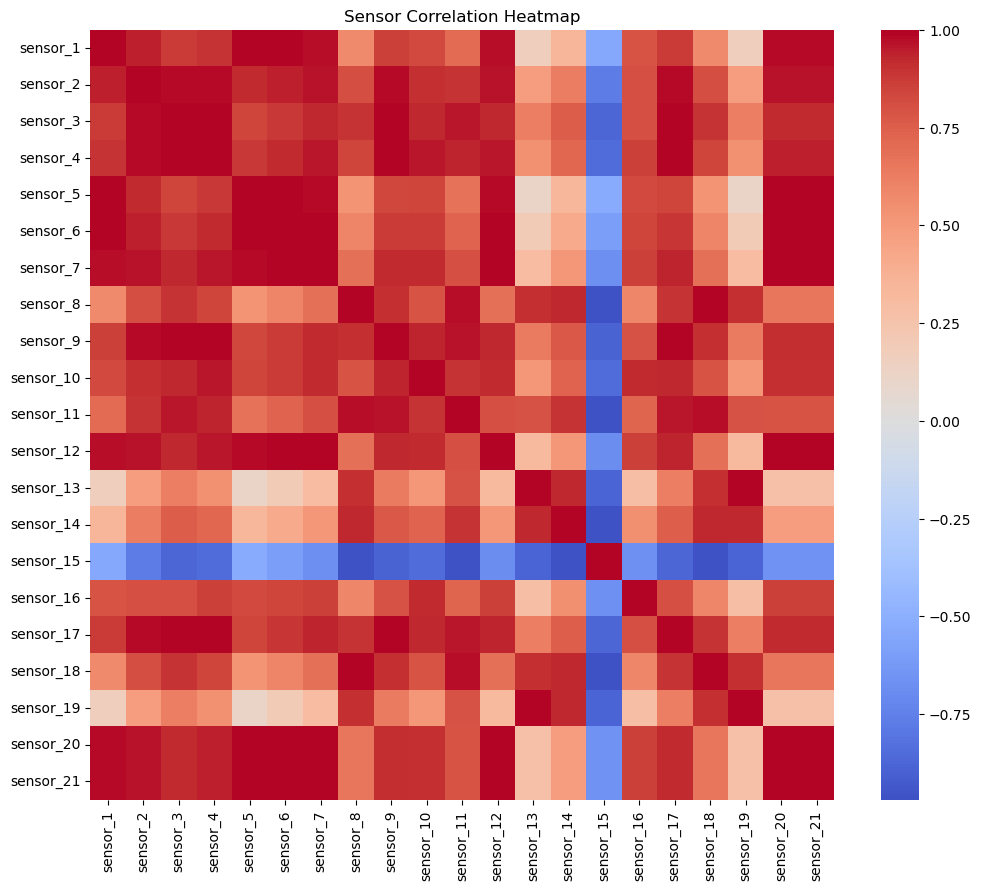

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df[[c for c in df.columns if 'sensor' in c]].corr(), cmap='coolwarm', center=0)
plt.title("Sensor Correlation Heatmap")
plt.show()

## Engine Sensor Time-Series

* **What it shows**: How selected sensor values evolve over cycles for one engine (e.g., engine_id=1).

* **Why valuable**:

    * You can see degradation patterns: some sensors drift steadily as the engine wears, others fluctuate randomly.

    * Identifies which sensors are potential “health indicators.”

    * This visualization is often the first clue about which signals should be engineered into features.

In [7]:
train_dfengine = 1
subset = df[df.engine_id == engine]
plt.figure(figsize=(12,6))
for s in [f'sensor_{i}' for i in range(1,22)]:
    plt.plot(subset['time_cycles'], subset[s], label=s)
plt.legend()
plt.title(f'Sensor Trends for Engine {engine}')
plt.xlabel("Cycle"); plt.ylabel("Sensor Reading")
plt.show()

NameError: name 'engine' is not defined

## Operational Settings Distribution

* **What it shows**: Histograms of the three operating condition variables.

* **Why valuable**: Engines don’t always operate under the same conditions; settings can affect sensor behavior and degradation speed.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, col in enumerate([f'operational_setting_{j}' for j in range(1,4)]):
    sns.histplot(df[col], bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## Sensor Vs. RUL Scatter

* **What it shows**: Relationship between a single sensor reading and the Remaining Useful Life.

* **Why valuable**:

    * Sensors that show a clear monotonic trend with RUL (e.g., values increase/decrease as RUL decreases) are predictive.

    * Scatter plots help identify sensors that correlate with failure timing vs. those that are just noise.

In [ ]:
sns.scatterplot(x='sensor_3', y='RUL', data=df.sample(5000))
plt.title("Sensor 3 vs RUL")
plt.show()


## Normalized Lifecycle Plots

* **What it shows**: Sensor trajectories averaged across engines, aligned by normalized cycle (0=start, 1=end-of-life).

* **Why valuable**:

    * Without normalization, engines run at different cycle counts, so trends are hard to compare.

    * Normalization reveals consistent degradation patterns across engines.

In [ ]:
normed = df.copy()
normed['cycle_norm'] = normed.groupby('engine_id')['time_cycles'].transform(
    lambda x: x / x.max()
)

avg_trend = normed.groupby('cycle_norm')['sensor_3'].mean()

plt.plot(avg_trend.index, avg_trend.values)
plt.title("Average Sensor 3 across Normalized Lifecycle")
plt.xlabel("Normalized Cycle (0=start,1=end)")
plt.ylabel("Mean Sensor Value")
plt.show()
